# Using numerical and categorical variables together

In the previous notebooks, we showed the required preprocessing to apply when
dealing with numerical and categorical variables. However, we decoupled the
process to treat each type individually. In this notebook, we show how to
combine these preprocessing steps.

We first load the entire adult census dataset.

In [1]:
import pandas as pd
url = "https://raw.githubusercontent.com/INRIA/scikit-learn-mooc/master/datasets/adult-census.csv"
adult_census = pd.read_csv(url)

# define target
target_name = 'class'
target = adult_census[target_name]

# define data, drop target and the duplicated column `"education-num"` as stated in the first notebook
data = adult_census.drop(columns=[target_name, 'education-num'])
data.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,?,Some-college,Never-married,?,Own-child,White,Female,0,0,30,United-States


## Selection based on data types

We separate categorical and numerical variables using their data types to
identify them, as we saw previously that `object` corresponds to categorical
columns (strings). We make use of `make_column_selector` helper to select the
corresponding columns.

In [2]:
data.dtypes

age                int64
workclass         object
education         object
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
dtype: object

In [7]:
from sklearn.compose import make_column_selector as selector
numerical_columns = selector(dtype_exclude=object)(data)
categorical_columns = selector(dtype_include=object)(data)

<div class="admonition caution alert alert-warning">
<p class="first admonition-title" style="font-weight: bold;">Caution!</p>
<p>Here, we know that <tt class="docutils literal">object</tt> data type is used to represent strings and thus
categorical features. Be aware that this is not always the case. Sometimes
<tt class="docutils literal">object</tt> data type could contain other types of information, such as dates that
were not properly formatted (strings) and yet relate to a quantity of
elapsed  time.</p>
<p class="last">In a more general scenario you should manually introspect the content of your
dataframe not to wrongly use <tt class="docutils literal">make_column_selector</tt>.</p>
</div>

## Dispatch columns to a specific processor

In the previous sections, we saw that we need to treat data differently
depending on their nature (i.e. numerical or categorical).

Scikit-learn provides a `ColumnTransformer` class which sends specific
columns to a specific transformer, making it easy to fit a single predictive
model on a dataset that combines both kinds of variables together
(heterogeneously typed tabular data).

We first define the columns depending on their data type:

* **one-hot encoding** is applied to categorical columns. Besides, we use
  `handle_unknown="ignore"` to solve the potential issues due to rare
  categories.
* **numerical scaling** numerical features which will be standardized.

Now, we create our `ColumnTransfomer` by specifying three values: the
preprocessor name, the transformer, and the columns. First, let's create the
preprocessors for the numerical and categorical parts.

In [8]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Scaling numerical data
numerical_preprocessor = StandardScaler()

# Encoding categorical data
categorical_preprocessor = OneHotEncoder(handle_unknown='ignore')

Now, we create the transformer and associate each of these preprocessors with
their respective columns.

In [9]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    [
        ("one-hot-encoder", categorical_preprocessor, categorical_columns),
        ("standard_scaler", numerical_preprocessor, numerical_columns),
    ]
)

We can take a minute to represent graphically the structure of a
`ColumnTransformer`:

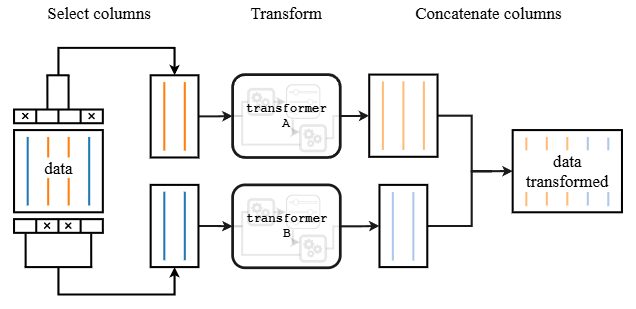

![columntransformer diagram](../figures/api_diagram-columntransformer.svg)

A `ColumnTransformer` does the following:

* It **splits the columns** of the original dataset based on the column names
  or indices provided. We obtain as many subsets as the number of transformers
  passed into the `ColumnTransformer`.
* It **transforms each subsets**. A specific transformer is applied to each
  subset: it internally calls `fit_transform` or `transform`. The output of
  this step is a set of transformed datasets.
* It then **concatenates the transformed datasets** into a single dataset.

The important thing is that `ColumnTransformer` is like any other scikit-learn
transformer. In particular it can be combined with a classifier in a
`Pipeline`:

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(preprocessor, LogisticRegression(max_iter=500))
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['age', 'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week'])])),
                ('logisticregression', LogisticRegression(max_iter=500))])

The final model is more complex than the previous models but still follows the
same API (the same set of methods that can be called by the user):

- the `fit` method is called to preprocess the data and then train the
  classifier of the preprocessed data;
- the `predict` method makes predictions on new data;
- the `score` method is used to predict on the test data and compare the
  predictions to the expected test labels to compute the accuracy.

Let's start by splitting our data into train and test sets.

In [11]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42
)


<div class="admonition caution alert alert-warning">
<p class="first admonition-title" style="font-weight: bold;">Caution!</p>
<p class="last">Be aware that we use <tt class="docutils literal">train_test_split</tt> here for didactic purposes, to show
the scikit-learn API. In a real setting one might prefer to use
cross-validation to also be able to evaluate the uncertainty of our estimation
of the generalization performance of a model, as previously demonstrated.</p>
</div>

Now, we can train the model on the train set.

In [12]:
_ = model.fit(data_train, target_train)

Then, we can send the raw dataset straight to the pipeline. Indeed, we do not
need to make any manual preprocessing (calling the `transform` or
`fit_transform` methods) as it is already handled when calling the `predict`
method. As an example, we predict on the five first samples from the test set.

In [13]:
data_test.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
7762,56,Private,HS-grad,Divorced,Other-service,Unmarried,White,Female,0,0,40,United-States
23881,25,Private,HS-grad,Married-civ-spouse,Transport-moving,Own-child,Other,Male,0,0,40,United-States
30507,43,Private,Bachelors,Divorced,Prof-specialty,Not-in-family,White,Female,14344,0,40,United-States
28911,32,Private,HS-grad,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States
19484,39,Private,Bachelors,Married-civ-spouse,Sales,Wife,White,Female,0,0,30,United-States


In [14]:
model.predict(data_test)[:5]

array([' <=50K', ' <=50K', ' >50K', ' <=50K', ' >50K'], dtype=object)

In [15]:
target_test[:5]

7762      <=50K
23881     <=50K
30507      >50K
28911     <=50K
19484     <=50K
Name: class, dtype: object

To get directly the accuracy score, we need to call the `score` method. Let's
compute the accuracy score on the entire test set.

In [16]:
model.score(data_test, target_test)

0.8575055278028008

## Evaluation of the model with cross-validation

As previously stated, a predictive model should be evaluated by
cross-validation. Our model is usable with the cross-validation tools of
scikit-learn as any other predictors:

In [17]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model, data, target, cv=5)
cv_results

{'fit_time': array([0.25636673, 0.24917936, 0.2121489 , 0.26921368, 0.27714801]),
 'score_time': array([0.02006578, 0.02106166, 0.02510142, 0.02142096, 0.02258945]),
 'test_score': array([0.85116184, 0.84993346, 0.8482801 , 0.85257985, 0.85544636])}

In [18]:
scores = cv_results["test_score"]
print(
    "The mean cross-validation accuracy is: "
    f"{scores.mean():.3f} ± {scores.std():.3f}"
)

The mean cross-validation accuracy is: 0.851 ± 0.002


The compound model has a higher predictive accuracy than the two models that
used numerical and categorical variables in isolation.

## Fitting a more powerful model

**Linear models** are nice because they are usually cheap to train, **small**
to deploy, **fast** to predict and give a **good baseline**.

However, it is often useful to check whether more complex models such as an
ensemble of decision trees can lead to higher predictive performance. In this
section we use such a model called **gradient-boosting trees** and evaluate
its generalization performance. More precisely, the scikit-learn model we use
is called `HistGradientBoostingClassifier`. Note that boosting models will be
covered in more detail in a future module.

For tree-based models, the handling of numerical and categorical variables is
simpler than for linear models:
* we do **not need to scale the numerical features**
* using an **ordinal encoding for the categorical variables** is fine even if
  the encoding results in an arbitrary ordering

Therefore, for `HistGradientBoostingClassifier`, the preprocessing pipeline is
slightly simpler than the one we saw earlier for the `LogisticRegression`:

In [19]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder

categorical_preprocessor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)

preprocessor = ColumnTransformer(
    [("categorical", categorical_preprocessor, categorical_columns)],
    remainder="passthrough",
)

model = make_pipeline(preprocessor, HistGradientBoostingClassifier())

Now that we created our model, we can check its generalization performance.

In [22]:
HistGradientBoostingClassifier?

Init signature:
HistGradientBoostingClassifier(
    loss='log_loss',
    *,
    learning_rate=0.1,
    max_iter=100,
    max_leaf_nodes=31,
    max_depth=None,
    min_samples_leaf=20,
    l2_regularization=0.0,
    max_features=1.0,
    max_bins=255,
    categorical_features='from_dtype',
    monotonic_cst=None,
    interaction_cst=None,
    warm_start=False,
    early_stopping='auto',
    scoring='loss',
    validation_fraction=0.1,
    n_iter_no_change=10,
    tol=1e-07,
    verbose=0,
    random_state=None,
    class_weight=None,
)
Docstring:     
Histogram-based Gradient Boosting Classification Tree.

This estimator is much faster than
:class:`GradientBoostingClassifier<sklearn.ensemble.GradientBoostingClassifier>`
for big datasets (n_samples >= 10 000).

This estimator has native support for missing values (NaNs). During
training, the tree grower learns at each split point whether samples
with missing values should go to the left or right child, based on the
potential gain. When 

In [23]:
# To stop the warning
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '4'  # Replace '4' with the number of cores you want to use

In [24]:
%%time
_ = model.fit(data_train, target_train)

CPU times: total: 3.7 s
Wall time: 402 ms


In [21]:
model.score(data_test, target_test)

0.8807632462533781

We can observe that we get significantly higher accuracies with the Gradient
Boosting model. This is often what we observe whenever the dataset has a large
number of samples and limited number of informative features (e.g. less than
1000) with a mix of numerical and categorical variables.

This explains why Gradient Boosted Machines are very popular among datascience
practitioners who work with tabular data.

In this notebook we:

* used a `ColumnTransformer` to apply different preprocessing for categorical
  and numerical variables;
* used a pipeline to chain the `ColumnTransformer` preprocessing and logistic
  regression fitting;
* saw that **gradient boosting methods** can outperform **linear models**.